<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Сравнение-предсказаний-с-фактическими-данными" data-toc-modified-id="Сравнение-предсказаний-с-фактическими-данными-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Сравнение предсказаний с фактическими данными</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

Загрузим данные и посмотрим на них.

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим на монотонность.

In [3]:
df.index.is_monotonic

True

Сделаем ресемплирование по 1 часу.

In [4]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

При помощи функции __seasonal_decompose()__, библиотеки __statsmodels__, посмотрим на графики трендов и сезонности.

In [5]:
decomposed = seasonal_decompose(df)

Text(0.5, 1.0, 'Seasonality day')

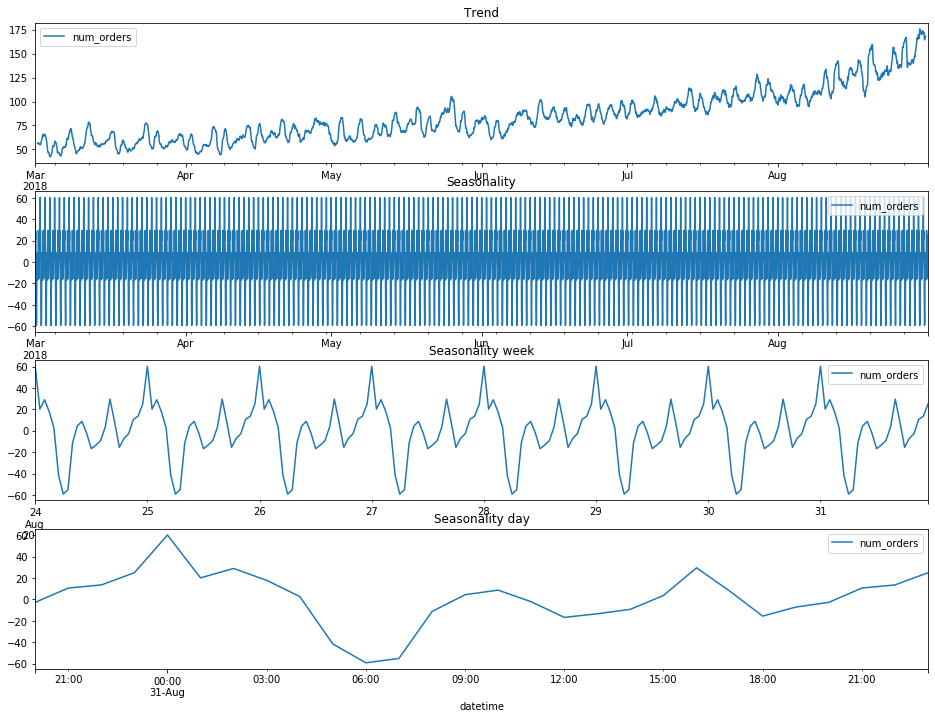

In [6]:
plt.figure(figsize=(16, 15))
plt.subplot(511)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(512)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(513)
decomposed.seasonal['2018-08-24':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality week')
plt.subplot(514)
decomposed.seasonal['2018-08-30 20:00:00':'2018-08-31 23:00:00'].plot(ax=plt.gca())
plt.title('Seasonality day')



Из графиков виден возрастающий тренд и ежедневная сезонность. В 6 часов утра просиходит спад заказов, вечером он плавно возрастает и в полночь наступает пик заказов такси.

Проверим наш ряд на стационарность методом Дики-Фуллера, используя функцию __adfuller()__ модуля __statsmodels__.

In [7]:
res = adfuller(df['num_orders']) 
print('Augmented Dickey-Fuller Statistic: %f' % res[0]) 
print('p-value: %f' % res[1]) 
print('Critical values:', res[4])
if res[0]> res[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

Augmented Dickey-Fuller Statistic: -3.068924
p-value: 0.028940
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


Наш ряд оказался стационарным, значит можно по нему делать предсказания.

## Обучение

Напишим функцию __make_features__, которая будет создавать признаки для обучения моделей.

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [9]:
make_features(df, 2, 24)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 6 columns):
num_orders      4392 non-null int64
dayofweek       4392 non-null int64
hour            4392 non-null int64
lag_1           4392 non-null float64
lag_2           4392 non-null float64
rolling_mean    4392 non-null float64
dtypes: float64(3), int64(3)
memory usage: 240.2 KB


Разделим наш датасет на обучающую и тестовую выборку. Выделим признаки и целевой признак.

In [10]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [11]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

### LinearRegression
Обучим модель LinearRegression.

In [12]:
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### LightGBM
Чтобы не загружать проверку ноутбука, ячейки с циклами подбора параметров переведены в RAW, а таблицы с результатами приведены ниже.

Лучшее значение RMSE у модели с n_estimators=100.  

| |n_estimators	| rmse_LGBMR|
 :--- | :---: | ---:
0	|1.0	|80.442150
1	|51.0	|44.190384
2	|101.0	|43.132970
3	|201.0	|44.177904
5	|251.0	|44.138648


| |max_depth |	rmse_LGBMR|
 :--- | :---: | ---:
0	|4.0	|43.331123
1	|5.0	|43.211722
2	|6.0	|44.199661
3	|7.0	|44.369206
4	|8.0	|43.602127
5	|9.0	|43.572452
6	|10.0	|43.498568
7	|11.0	|43.946856

Выберем глубину - 5.

In [13]:
LGBMR_model = LGBMRegressor(n_estimators=100, max_depth=5)
LGBMR_model.fit(features_train, target_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

###  CatBoost
Обучим модель CatBoostRegressor. Выделим категориальные признаки, и подберем значение глубины.

In [14]:
cat = ['dayofweek', 'hour']

Выберем глубину 6.

| |max_depth |	rmse_cat |
:--- | :---: | ---:
0	|4.0	|47.027629
1	|5.0	|48.164611
2	|6.0	|45.314579
3	|7.0	|46.716413
4	|8.0	|45.823927
5	|9.0	|46.608596
6	|10.0	|45.267395
7	|11.0	|46.182710
8	|12.0	|45.272958


In [15]:
model_CatBoost = CatBoostRegressor(loss_function="RMSE", iterations=200, learning_rate=0.5, max_depth=6)
model_CatBoost.fit(features_train, target_train, cat_features=cat, verbose=100)

0:	learn: 30.2137462	total: 50.1ms	remaining: 9.98s
100:	learn: 17.8727227	total: 2.35s	remaining: 2.31s
199:	learn: 15.0366380	total: 4.71s	remaining: 0us


### DecisionTreeRegressor

In [16]:
data_max_depth = pd.DataFrame(columns=['max_depth', 'rmse_DTR'])
for depth in range(5, 20):
    model_DTR = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model_DTR.fit(features_train, target_train)
    pred_DTR = model_DTR.predict(features_test)
    data_max_depth = data_max_depth.append({'max_depth': depth, 
                       'rmse_DTR': mean_squared_error(target_test, pred_DTR)** 0.5},
                       ignore_index=True)
    
data_max_depth

,max_depth,rmse_DTR
0,5.0,57.235552
1,6.0,52.854860
2,7.0,55.328427
3,8.0,54.796935
4,9.0,55.884797
5,10.0,58.442948
6,11.0,56.053975
7,12.0,56.110701
8,13.0,57.532830
9,14.0,57.504441


Выберем глубину 6.

In [17]:
model_DTR = DecisionTreeRegressor(random_state=12345, max_depth=6)
model_DTR.fit(features_train, target_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')

## Тестирование

Проверим обученные модели на тестовой выборке и сравним значение RMSE.

In [18]:
pred_lr = lr_model.predict(features_test)
mean_squared_error(target_test, pred_lr)** 0.5

51.29636818907293

In [19]:
pred_LGBMR = LGBMR_model.predict(features_test)
mean_squared_error(target_test, pred_LGBMR)** 0.5

43.211721816231645

In [20]:
pred_CatBoost = model_CatBoost.predict(features_test)
mean_squared_error(target_test, pred_CatBoost)** 0.5

45.31457882107338

In [21]:
pred_DTR = model_DTR.predict(features_test)
mean_squared_error(target_test, pred_DTR)** 0.5

52.854859956492774

In [22]:
data = [[51.29],
        [ 43.211],
        [ 45.31],
        [52.85]]
model = ["LinearRegression", "LGBM", "CatBoost", "DecisionTreeRegressor"]
pd.DataFrame(data=data, index=model, columns=["RMSE"])

,RMSE
LinearRegression,51.290
LGBM,43.211
CatBoost,45.310
DecisionTreeRegressor,52.850


### Сравнение предсказаний с фактическими данными

In [23]:
target_test_2days = target_test['2018-08-28 23:00:00':'2018-08-30 23:00:00']
features_test_2days = features_test['2018-08-28 23:00:00':'2018-08-30 23:00:00']
pred_LGBMR_2days = LGBMR_model.predict(features_test_2days)

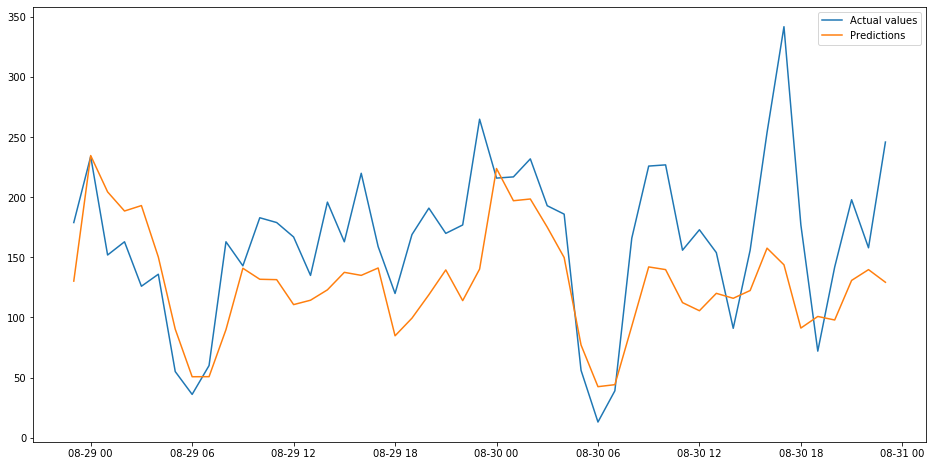

In [24]:
plt.figure(figsize=(16, 8))
plt.plot(target_test_2days, label='Actual values')
plt.plot(target_test_2days.index, pred_LGBMR_2days, label='Predictions')
plt.legend()
plt.show()

Модель сильно сглаживает (т.е. плохо предсказывает) пик нагрузки в 16.00 (не могу понять с чем может быть связана эта нагрузка на такси в аэропорт в четверг, хоть и перед 1 сентября). Зато модель хорошо справляется с предсказанием полуночной нагрузки. В целом модель предсказывает меньшую нагрузку, чем есть на самом деле.

## Вывод

В данном проекте было необходимо построить модель для прогнозирования количества заказов такси на следующий час во время пиковой нагрузки для компании «Чётенькое такси».

На основе исторических данных были подготовлены признаки для обучения моделей и обучены 4 модели регрессии.

Лучшее значение RMSE на тестовой выборке получилось у модели LightGBM - 43,21.